### インポート

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import requests
import time
from bs4 import BeautifulSoup

### アベレージヒッターのOPS

In [ ]:
file_path = 'stats_bat.csv'
db_name = 'baseball.db'

try:
    df = pd.read_csv(file_path, encoding='cp932')

    with sqlite3.connect(db_name) as conn:
        df.to_sql('players', conn, if_exists='replace', index=False)
        cur = conn.cursor()

        sql_select = '''
            SELECT 
                season_year, 
                team_name,    -- ★追加: チーム名
                player_name, 
                g, 
                (h * 1.0 / ab) as ba,     -- 打率
                hr, 
                (tb * 1.0 / ab) as slg,   -- 長打率
                
                -- OPSの計算
                (
                  ((h + bb + hbp) * 1.0 / (ab + bb + hbp + sf)) 
                  + 
                  (tb * 1.0 / ab)
                ) as ops

            FROM players 
            WHERE 
                  ab > 0 
              AND (h * 1.0 / ab) >= 0.250
              AND hr <= 9
              AND g >= 100
              AND season_year NOT IN (2021, 2022)
            
            ORDER BY season_year ASC, ops DESC
        '''
        
        cur.execute(sql_select)
        results = cur.fetchall()

        print("-" * 100)
        print(f"条件一致: {len(results)}件")
        print("-" * 100)
        
        for row in results:

            print(f"{row[0]}年 | {row[1]:<6} | {row[2]:<6} | {row[3]}試合 | 打率:{row[4]:.3f} | 本塁打:{row[5]} | 長打率:{row[6]:.3f} | OPS:{row[7]:.3f}")

except Exception as e:
    print(f"エラー: {e}")

----------------------------------------------------------------------------------------------------
条件一致: 86件
----------------------------------------------------------------------------------------------------
2023年 | 阪神     | 近本　光司  | 129試合 | 打率:0.285 | 本塁打:8 | 長打率:0.429 | OPS:0.809
2023年 | ロッテ    | 岡　大海   | 109試合 | 打率:0.282 | 本塁打:7 | 長打率:0.417 | OPS:0.788
2023年 | 広島     | 西川　龍馬  | 109試合 | 打率:0.305 | 本塁打:9 | 長打率:0.423 | OPS:0.760
2023年 | 楽天     | 辰己　涼介  | 133試合 | 打率:0.263 | 本塁打:9 | 長打率:0.385 | OPS:0.726
2023年 | 広島     | 秋山　翔吾  | 115試合 | 打率:0.274 | 本塁打:4 | 長打率:0.376 | OPS:0.709
2023年 | 楽天     | 岡島　豪郎  | 114試合 | 打率:0.266 | 本塁打:6 | 長打率:0.371 | OPS:0.698
2023年 | ソフトバンク | 柳町　達   | 116試合 | 打率:0.257 | 本塁打:0 | 長打率:0.322 | OPS:0.696
2023年 | オリックス  | 紅林　弘太郎 | 127試合 | 打率:0.275 | 本塁打:8 | 長打率:0.377 | OPS:0.695
2023年 | 阪神     | 中野　拓夢  | 143試合 | 打率:0.285 | 本塁打:2 | 長打率:0.343 | OPS:0.692
2023年 | 中日     | 岡林　勇希  | 143試合 | 打率:0.279 | 本塁打:3 | 長打率:0.365 | OPS:0.688
2023年 | ソフトバンク | 中村　晃   | 136試合 | 打率:0

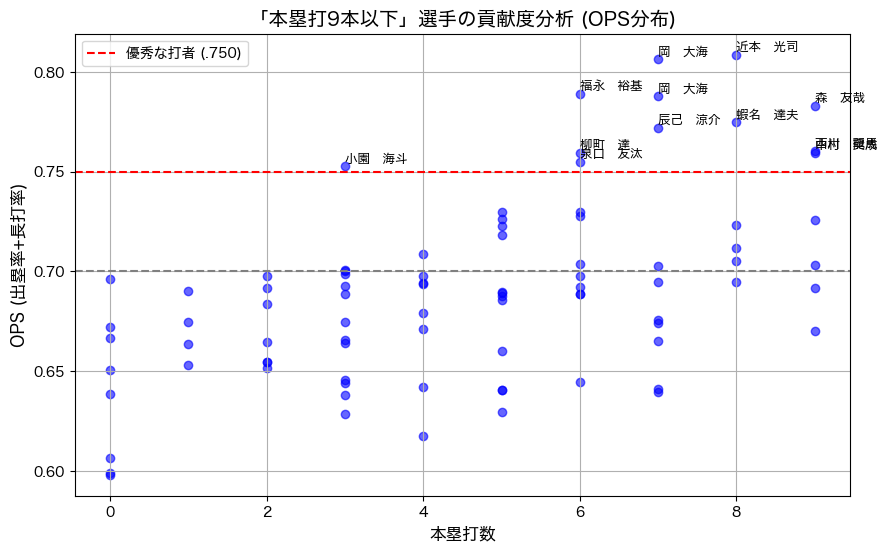

In [ ]:
plt.rcParams['font.family'] = 'Hiragino Sans'

file_path = 'stats_bat.csv'
db_name = 'baseball.db'

try:
    with sqlite3.connect(db_name) as conn:
        # 分析用のデータを取得
        sql_select = '''
            SELECT 
                player_name, 
                hr, 
                (
                  ((h + bb + hbp) * 1.0 / (ab + bb + hbp + sf)) + (tb * 1.0 / ab)
                ) as ops
            FROM players 
            WHERE ab > 0 
              AND (h * 1.0 / ab) >= 0.250
              AND hr <= 9
              AND g >= 100
              AND season_year NOT IN (2021, 2022)
        '''
        df_graph = pd.read_sql(sql_select, conn)

        # 散布図の作成
        plt.figure(figsize=(10, 6))
        
        # 散布図プロット
        plt.scatter(df_graph['hr'], df_graph['ops'], alpha=0.6, color='blue')

        # 平均線の描画
        plt.axhline(y=0.700, color='gray', linestyle='--' )
        plt.axhline(y=0.750, color='red', linestyle='--', label='優秀な打者 (.750)')

        # OPSが高い上位の選手名を表示する
        for i, row in df_graph.iterrows():
            if row['ops'] >= 0.750:
                # 名前を表示
                plt.text(row['hr'], row['ops'] + 0.002, row['player_name'], fontsize=9)

        plt.title('「本塁打9本以下」選手の貢献度分析 (OPS分布)', fontsize=14)
        plt.xlabel('本塁打数', fontsize=12)
        plt.ylabel('OPS (出塁率+長打率)', fontsize=12)
        plt.grid(True)
        plt.legend()
        
        # グラフ表示
        plt.show()

except Exception as e:
    print(f"エラー: {e}")

### 考察

In [ ]:
#   優秀な選手のOPS平均目安は.750以上
#   小園海斗、泉口友太、柳町樹、福永祐基、辰巳涼介、岡大海、蝦名達夫、近本光司、森友哉
#   順位が上位の選手がずらりと並んでいることから、チームへの貢献度が高いのではないかと思った

## ホームランヒッター

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# 日本語表示のための設定 (環境によって適宜調整してください)
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = False # マイナス記号の表示

# --- 1. データの読み込みと前処理 (エンコーディング修正済み) ---

file_name = "stats_bat.csv"
df_bat = pd.DataFrame() # df_batを初期化

try:
    # 最初にShift-JISで読み込みを試みる
    df = pd.read_csv(file_name, encoding='Shift-JIS')
    print("✅ Shift-JISでファイルを読み込みました。")
except UnicodeDecodeError:
    try:
        # Shift-JISで失敗した場合、cp932 (WindowsのShift-JIS)で試す
        df = pd.read_csv(file_name, encoding='cp932')
        print("✅ cp932でファイルを読み込みました。")
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました。エンコーディングエラー: {e}")
        sys.exit() # 読み込みエラーでプログラムを終了

# 必要なカラムを選択
columns_to_keep = ['player_id', 'player_name', 'pa', 'ab', 'h', 'tb', 'bb', 'hbp', 'sf', 'so', 'hr']
df_bat = df[columns_to_keep].copy()

# 規定打席数（今回は100打席以上）未満の選手を除外
MIN_PA = 100
df_bat = df_bat[df_bat['pa'] >= MIN_PA].reset_index(drop=True)

print(f"✅ データ読み込み完了。規定打席数 ({MIN_PA} PA) 以上の選手数: {len(df_bat)}名")
print("-" * 30)

# --- 2. OPSの計算 ---

# 出塁率 (OBP) = (H + BB + HBP) / (AB + BB + HBP + SF)
df_bat['OBP_denominator'] = df_bat['ab'] + df_bat['bb'] + df_bat['hbp'] + df_bat['sf']
df_bat['OBP_numerator'] = df_bat['h'] + df_bat['bb'] + df_bat['hbp']
df_bat['OBP'] = np.where(df_bat['OBP_denominator'] > 0, df_bat['OBP_numerator'] / df_bat['OBP_denominator'], np.nan)

# 長打率 (SLG) = TB / AB
df_bat['SLG'] = np.where(df_bat['ab'] > 0, df_bat['tb'] / df_bat['ab'], np.nan)

# OPS = OBP + SLG
df_bat['OPS'] = df_bat['OBP'] + df_bat['SLG']

# --- 3. 分析指標の計算 ---

# 三振率 K% = SO / PA
df_bat['K_Rate'] = df_bat['so'] / df_bat['pa']

# ホームラン率 HR/PA = HR / PA
df_bat['HR_Rate'] = df_bat['hr'] / df_bat['pa']

df_bat.dropna(subset=['OPS', 'K_Rate', 'HR_Rate'], inplace=True)

print("✅ OPSおよび分析指標の計算完了。")
print("-" * 30)

# --- 4. 相関分析と可視化 ---
# ※ここでは分析結果の概要出力とグラフのファイル保存のみ行います

# A. OPSと三振率の関係
corr_k_ops = df_bat['K_Rate'].corr(df_bat['OPS'])
print(f"三振率 (K_Rate) と OPS の相関係数: {corr_k_ops:.4f}")
plt.figure(figsize=(8, 6))
sns.scatterplot(x='K_Rate', y='OPS', data=df_bat, alpha=0.6)
plt.title(f'OPSと三振率の関係 (相関係数: {corr_k_ops:.4f})')
plt.xlabel('三振率 (SO / PA)')
plt.ylabel('OPS')
plt.savefig('ops_vs_k_rate.png')
plt.close()

# B. OPSとホームラン率の関係
corr_hr_ops = df_bat['HR_Rate'].corr(df_bat['OPS'])
print(f"ホームラン率 (HR_Rate) と OPS の相関係数: {corr_hr_ops:.4f}")
plt.figure(figsize=(8, 6))
sns.scatterplot(x='HR_Rate', y='OPS', data=df_bat, alpha=0.6)
plt.title(f'OPSとホームラン率の関係 (相関係数: {corr_hr_ops:.4f})')
plt.xlabel('ホームラン率 (HR / PA)')
plt.ylabel('OPS')
plt.savefig('ops_vs_hr_rate.png')
plt.close()

# C. 高三振・高OPSバッターの確認
k_rate_q3 = df_bat['K_Rate'].quantile(0.75)
high_k_high_ops_players = df_bat[df_bat['K_Rate'] >= k_rate_q3].sort_values(by='OPS', ascending=False)
print(f"### 三振率が上位25% (K_Rate >= {k_rate_q3:.4f}) のバッター上位10名 (OPS順) ###")
print(high_k_high_ops_players[['player_name', 'pa', 'so', 'hr', 'K_Rate', 'HR_Rate', 'OBP', 'SLG', 'OPS']].head(10).to_markdown(index=False, floatfmt=".3f"))
print("-" * 30)


# --- 5. データベースへの挿入 ---

db_name = 'baseball_analysis.db'
table_name = 'batter_performance_ops'
conn = None

try:
    conn = sqlite3.connect(db_name)
    print(f"✅ データベース '{db_name}' に接続しました。")

    # 挿入するデータフレームを、必要なカラムだけに絞る
    df_result = df_bat[['player_id', 'player_name', 'pa', 'so', 'hr', 'K_Rate', 'HR_Rate', 'OBP', 'SLG', 'OPS']].copy()
    
    # DBへの書き込み (テーブルが既に存在する場合は置き換える)
    df_result.to_sql(
        name=table_name, 
        con=conn, 
        if_exists='replace', 
        index=False 
    )
    
    print(f"✅ 分析結果をテーブル '{table_name}' に挿入しました。")
    
    # 確認のために、DBから最初の5行を読み出して表示
    df_check = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 5", conn)
    print("\n--- 挿入されたデータの確認 (最初の5行) ---")
    print(df_check.to_markdown(index=False, floatfmt=".3f"))
    
except Exception as e:
    print(f"データベース処理中にエラーが発生しました: {e}")

finally:
    if conn:
        conn.close()
        print("\n✅ データベース接続を閉じました。")

✅ cp932でファイルを読み込みました。
✅ データ読み込み完了。規定打席数 (100 PA) 以上の選手数: 892名
------------------------------
✅ OPSおよび分析指標の計算完了。
------------------------------
三振率 (K_Rate) と OPS の相関係数: -0.1185
ホームラン率 (HR_Rate) と OPS の相関係数: 0.6911
### 三振率が上位25% (K_Rate >= 0.2279) のバッター上位10名 (OPS順) ###
| player_name   |   pa |   so |   hr |   K_Rate |   HR_Rate |   OBP |   SLG |   OPS |
|:--------------|-----:|-----:|-----:|---------:|----------:|------:|------:|------:|
| 村上　宗隆    |  224 |   64 |   22 |    0.286 |     0.098 | 0.379 | 0.663 | 1.043 |
| オースティン  |  439 |  111 |   28 |    0.253 |     0.064 | 0.405 | 0.601 | 1.006 |
| 佐藤　輝明    |  597 |  163 |   40 |    0.273 |     0.067 | 0.345 | 0.579 | 0.924 |
| レイエス      |  368 |   90 |   25 |    0.245 |     0.068 | 0.348 | 0.564 | 0.912 |
| サンタナ      |  215 |   73 |   15 |    0.340 |     0.070 | 0.353 | 0.550 | 0.904 |
| サンタナ      |  418 |  103 |   19 |    0.246 |     0.045 | 0.366 | 0.511 | 0.877 |
| 筒香　嘉智    |  257 |   59 |   20 |    0.230 |     0.078 | 0.327 | 0.549 

/var/folders/j8/dfz5dvkd3cz2jst43x9_pzzr0000gn/T/ipykernel_61614/2669876463.py:78: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.savefig('ops_vs_k_rate.png')
/var/folders/j8/dfz5dvkd3cz2jst43x9_pzzr0000gn/T/ipykernel_61614/2669876463.py:78: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  plt.savefig('ops_vs_k_rate.png')
/var/folders/j8/dfz5dvkd3cz2jst43x9_pzzr0000gn/T/ipykernel_61614/2669876463.py:78: UserWarning: Glyph 25391 (\N{CJK UNIFIED IDEOGRAPH-632F}) missing from font(s) DejaVu Sans.
  plt.savefig('ops_vs_k_rate.png')
/var/folders/j8/dfz5dvkd3cz2jst43x9_pzzr0000gn/T/ipykernel_61614/2669876463.py:78: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.savefig('ops_vs_k_rate.png')
/var/folders/j8/dfz5dvkd3cz2jst43x9_pzzr0000gn/T/ipykernel_61614/2669876463.py:78: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
 